In [1]:
BAGNUMBER = 3
METHOD = 'opencv - epnp'
PLOTTING = '2D'

In [2]:
import numpy as np
import cv2
import rosbag 
import transforms3d.quaternions as quat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
from PIL import Image

In [3]:
#######################
### ALL PNP METHODS ###
#######################

def opencv_epnp(coor2d, coor3d, cam_matrix, dis_matrix):
    success, rotation, translation = cv2.solvePnP(coor3d, coor2d, cam_matrix, dis_matrix, flags=cv2.SOLVEPNP_EPNP)
    rotation_matrix, _ = cv2.Rodrigues(rotation)
    transformation = np.vstack((np.hstack((rotation_matrix, translation)), [0,0,0,1]))
    # transformation = np.linalg.inv(transformation)
    translation = transformation[:3, 3]
    rotation_matrix = transformation[:3, :3]

    rotation_quaternion = quat.mat2quat(rotation_matrix)
    rotation = rotation_quaternion/np.linalg.norm(rotation_quaternion)
    return success, rotation, translation

def func2(coor2d, coor3d, cam_matrix, dis_matrix):
    print("NOT YET")
    return False, np.array([0, 0, 0]), np.array([0, 0, 0])

MethodDict = {
    'opencv - epnp' : opencv_epnp,
    '2' : func2
    }

In [4]:
################
### ALL BAGS ###
################

BagPaths = {
    1: '/home/annika/ITRL/kth_thesis/rosbag/2024-01-22/UnitTest_Case1.bag',
    2: '/home/annika/ITRL/kth_thesis/rosbag/2024-01-23/2024-01-23-17-11-22.bag',
    3: '/home/annika/ITRL/kth_thesis/rosbag/2024-01-24/2024-01-24-14-24-58.bag'
    }

Bag = BagPaths[BAGNUMBER]

In [5]:
#########################
### GET DATA FROM BAG ###
#########################

Coor3dAll = []
Coor2dAll = []
IdAll = []

cam_matrix = []
dis_matrix = []

Svea5 = []
# Open the bag file
with rosbag.Bag(Bag, 'r') as bag:
    # Iterate through messages in the bag
    for topic, msg, t in bag.read_messages():
        coor2d = []
        coor3d = []
        id = []
        # Process the messages based on the topic
        if topic == '/aruco/detection':
            for aruco in msg.arucos:
                id.append(aruco.marker.id)
                coor2d.append([aruco.image_x, aruco.image_y])
                coor3d.append([aruco.marker.pose.pose.position.x, aruco.marker.pose.pose.position.y, aruco.marker.pose.pose.position.z])
            coor2d = np.array(coor2d)
            coor3d = np.array(coor3d)
            Coor2dAll.append(coor2d)
            Coor3dAll.append(coor3d)
            IdAll.append(id)
        if topic == '/qualisys/svea5/pose':
            Svea5.append([msg.pose.position.y - 0.06, -msg.pose.position.x + 0.06])

dis_matrix = np.array([0.06295602826790396, -0.1840231372229633, -0.004945725015870819, 0.01208470957502327, 0])
cam_matrix = np.array([514.578298266441, 0, 340.0718185830948, 0, 514.8684665452305, 231.4918039429434, 0, 0, 1]).reshape(3,3)
Svea5 = np.array(Svea5)

In [6]:
#####################
#### TESTING PNP ####
#####################

Successes = []
Rotations = []
Translations = []
for coor2d, coor3d in zip(Coor2dAll, Coor3dAll):
    if len(coor2d) >= 4:
        suc, rot, trans = MethodDict[METHOD](coor2d, coor3d, cam_matrix, dis_matrix)
        Successes.append(suc)
        Rotations.append(rot)
        Translations.append(trans)
    else:
        Successes.append(False)
        Rotations.append(np.array([np.nan, np.nan, np.nan, np.nan]))
        Translations.append(np.array([np.nan, np.nan, np.nan]))


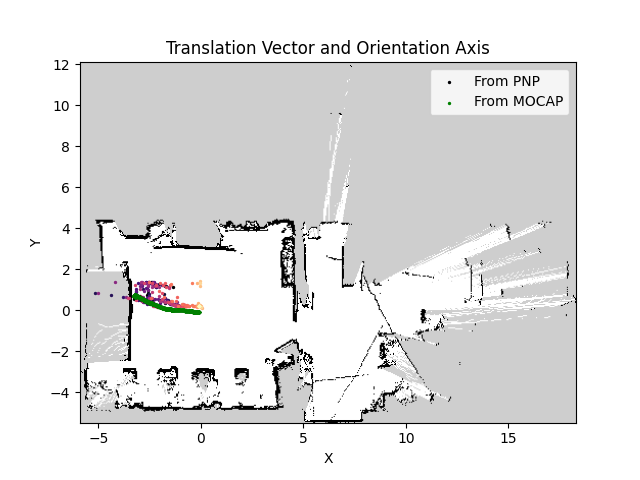

In [14]:
######################
###### PLOTTING ######
######################
%matplotlib widget

def Plot3D():
    # Plot translation vector and orientation
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    values = np.linspace(0, 1, len(Coor2dAll))
    Colors = cm.magma(values)

    for suc, rot, trans, color in zip(Successes, Rotations, Translations, Colors):
        if suc:
            # Plot translation vector
            # ax.scatter(*trans, color='r', label='Translation Vector')
            ax.scatter(*trans, color=color)
        
            # Plot orientation axis
            orientation_axis = quat.qmult(quat.qmult(rot, [0, 0, 0, 1]), quat.qinverse(rot))[1:4]
            ax.quiver(*trans, *orientation_axis, color='b', length=0.2, arrow_length_ratio=0.7)
            # ax.quiver(*trans, *orientation_axis, color='b', label='Orientation Axis', length=0.002, arrow_length_ratio=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Translation Vector and Orientation Axis')
    ax.legend()

    # Set up interactive 3D rotation
    ax.view_init(elev=20, azim=30)  # Set initial view angle

    plt.show()
    colormap = cm.magma  # You can replace 'viridis' with any other colormap

    # Create a gradient of colors
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    fig, ax = plt.subplots(figsize=(6, 1))
    ax.imshow(gradient, aspect='auto', cmap=colormap)
    ax.set_axis_off()
    
def Plot2D():
    # Load the map image
    image_path = '/home/annika/ITRL/kth_thesis/src/svea_core/maps/sml.pgm'  # Replace with your .pgm file path
    map_img = Image.open(image_path)
    # Plot translation vector and orientation
    fig, ax = plt.subplots()
    xmin, xmax, ymin, ymax = -5.9, 18.3, -5.5, 12.1
    ax.imshow(map_img, cmap='gray', extent=[xmin, xmax, ymin, ymax])  # Set the extent as per your map's coordinate system

    values = np.linspace(0, 1, len(Coor2dAll))
    Colors = cm.magma(values)
    values = np.linspace(0, 1, len(Svea5))
    ColorsSvea = cm.inferno(values)
    FirstPlot = True
    for suc, rot, trans, color in zip(Successes, Rotations, Translations, Colors):
        if suc:
            # Plot translation vector
            if FirstPlot:
                ax.scatter(trans[0], trans[1], color=color, s=2, label='From PNP')
                FirstPlot = False
            else:
                ax.scatter(trans[0], trans[1], color=color, s=2)
            
            # Plot orientation axis
            orientation_axis = quat.qmult(quat.qmult(rot, [0, 0, 0, 1]), quat.qinverse(rot))[1:4]
            # ax.quiver(trans[0], trans[1], orientation_axis[0], orientation_axis[1], color='b', scale=40)

    ax.scatter(Svea5[:,0],Svea5[:,1], color='g', s=2, label='From MOCAP')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Translation Vector and Orientation Axis')
    ax.legend()

    # Limit the range of x and y
    ax.set_xlim([xmin, xmax])  # Set your min and max x values
    ax.set_ylim([ymin, ymax])  # Set your min and max y values

    plt.show()


PlotDict = {
    '2D': Plot2D,
    '3D': Plot3D
    }

PlotDict[PLOTTING]()
